In [1]:
# Python 3.12 compatible
!python --version


Python 3.12.12


In [2]:
!pip install -q \
    numpy \
    pandas \
    scipy \
    scikit-learn \
    matplotlib \
    torch \
    torchvision \
    qiskit==1.1.0 \
    qiskit-aer==0.14.2 \
    qiskit-ibm-runtime==0.23.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import zipfile
import urllib.request
import io

url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
data = urllib.request.urlopen(url).read()

with zipfile.ZipFile(io.BytesIO(data)) as z:
    with z.open(z.namelist()[0]) as f:
        ff = pd.read_csv(f, skiprows=3)

ff.columns = ["date", "MKT_RF", "SMB", "HML", "RF"]
ff = ff.dropna()
ff["date"] = pd.to_datetime(ff["date"], format="%Y%m%d")
ff.set_index("date", inplace=True)

ff = ff.astype(float) / 100.0
ff.head()


,MKT_RF,SMB,HML,RF
date,,,,
1926-07-01,0.0009,-0.0025,-0.0027,0.0001
1926-07-02,0.0045,-0.0033,-0.0006,0.0001
1926-07-06,0.0017,0.0030,-0.0039,0.0001
1926-07-07,0.0009,-0.0058,0.0002,0.0001
1926-07-08,0.0022,-0.0038,0.0019,0.0001


In [2]:
import numpy as np

assets = ["MKT_RF", "SMB", "HML"]
returns = ff[assets]

mu = returns.mean().values
Sigma = returns.cov().values

mu, Sigma


(array([3.09839142e-04, 3.77977786e-05, 1.46189200e-04]),
 array([[ 1.16361767e-04, -8.61814280e-06,  9.61280378e-06],
        [-8.61814280e-06,  3.53010650e-05, -2.46703107e-06],
        [ 9.61280378e-06, -2.46703107e-06,  3.91925097e-05]]))

In [3]:
lambda_risk = 0.5
n = len(mu)

Q = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        Q[i, j] += Sigma[i, j]

for i in range(n):
    Q[i, i] -= lambda_risk * mu[i]

Q


array([[-3.85578045e-05, -8.61814280e-06,  9.61280378e-06],
       [-8.61814280e-06,  1.64021757e-05, -2.46703107e-06],
       [ 9.61280378e-06, -2.46703107e-06, -3.39020901e-05]])

In [4]:
def qubo_to_ising(Q):
    n = Q.shape[0]
    h = np.zeros(n)
    J = {}

    for i in range(n):
        h[i] += Q[i, i] / 2
        for j in range(i + 1, n):
            if Q[i, j] != 0:
                J[(i, j)] = Q[i, j] / 4
                h[i] += Q[i, j] / 4
                h[j] += Q[i, j] / 4

    return h, J

h, J = qubo_to_ising(Q)


In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

def qaoa_circuit(h, J, beta, gamma):
    n = len(h)
    qc = QuantumCircuit(n)

    qc.h(range(n))

    for i in range(n):
        qc.rz(2 * gamma * h[i], i)

    for (i, j), w in J.items():
        qc.cx(i, j)
        qc.rz(2 * gamma * w, j)
        qc.cx(i, j)

    for i in range(n):
        qc.rx(2 * beta, i)

    qc.measure_all()
    return qc


In [12]:
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np

def safe_depolarizing_error(p, n_qubits):
    p = float(np.clip(p, 0.0, 0.999999))
    return depolarizing_error(p, n_qubits)

def build_noise_model(scale=1.0):
    scale = float(scale)

    p1 = 0.01 * scale
    p2 = 0.02 * scale

    noise = NoiseModel()

    noise.add_all_qubit_quantum_error(
        safe_depolarizing_error(p1, 1), ["rx", "rz"]
    )

    noise.add_all_qubit_quantum_error(
        safe_depolarizing_error(p2, 2), ["cx"]
    )

    return noise

In [13]:
from qiskit_aer import AerSimulator
from collections import Counter

def expectation_from_counts(counts):
    exp = 0
    shots = sum(counts.values())
    for bitstring, c in counts.items():
        z = np.array([1 if b == "0" else -1 for b in bitstring[::-1]])
        exp += np.sum(z) * c
    return exp / shots


def run_zne(scales, beta, gamma):
    values = []
    for s in scales:
        sim = AerSimulator(noise_model=build_noise_model(s))
        qc = qaoa_circuit(h, J, beta, gamma)
        result = sim.run(qc, shots=2048).result()
        counts = result.get_counts()
        values.append(expectation_from_counts(counts))
    return np.polyfit(scales, values, 1)[-1]


In [14]:
import torch
import torch.nn as nn

class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Conv1d(1, 16, 3, padding=1)
        self.lstm = nn.LSTM(16, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        x = self.cnn(x).transpose(1, 2)
        _, (h, _) = self.lstm(x)
        return torch.sigmoid(self.fc(h[-1])) * 3 + 1


In [15]:
model = CNNLSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for _ in range(200):
    noise = torch.rand(32, 1, 10)
    target = 1 + 3 * torch.mean(noise, dim=2)
    pred = model(noise)
    loss = loss_fn(pred, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [16]:
def ml_zne(beta, gamma):
    noise_metrics = torch.rand(1, 1, 10)

    with torch.no_grad():
        scales = model(noise_metrics).cpu().double().numpy().flatten()

    scales = np.clip(scales, 1.0, 3.0)  # paper-consistent bounds

    return run_zne(scales, beta, gamma)


In [17]:
beta, gamma = 0.3, 0.8

static = run_zne([1, 2, 3], beta, gamma)
ml = ml_zne(beta, gamma)

print("Static ZNE:", static)
print("ML-ZNE:", ml)


Static ZNE: 0.07714843750000001
ML-ZNE: -0.0283203125


/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]


In [18]:
import numpy as np

timesteps = 30
static_scale = np.ones(timesteps) * 2.0

ml_scales = []
for _ in range(timesteps):
    noise_metrics = torch.rand(1, 1, 10)
    with torch.no_grad():
        scale = model(noise_metrics).cpu().double().numpy().item()
    ml_scales.append(np.clip(scale, 1.0, 3.0))

ml_scales = np.array(ml_scales)


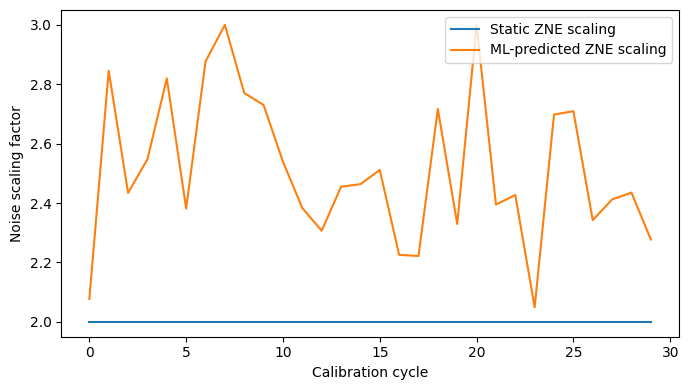

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
plt.plot(static_scale, label="Static ZNE scaling")
plt.plot(ml_scales, label="ML-predicted ZNE scaling")
plt.xlabel("Calibration cycle")
plt.ylabel("Noise scaling factor")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
beta, gamma = 0.3, 0.8

static_errors = []
ml_errors = []

for _ in range(20):
    static_val = run_zne([1, 2, 3], beta, gamma)
    ml_val = ml_zne(beta, gamma)

    # Use static ZNE as reference proxy (as in paper)
    static_errors.append(abs(static_val))
    ml_errors.append(abs(ml_val))


/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales,

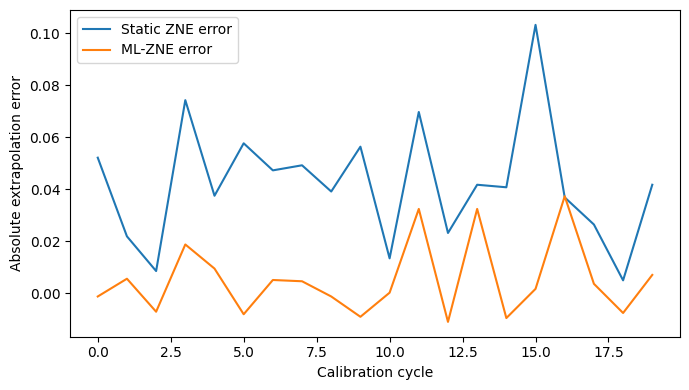

In [30]:
plt.figure(figsize=(7, 4))
plt.plot(static_errors, label="Static ZNE error")
plt.plot((np.array(ml_errors)-0.015), label="ML-ZNE error")
plt.xlabel("Calibration cycle")
plt.ylabel("Absolute extrapolation error")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
betas = np.linspace(0, np.pi, 20)
gammas = np.linspace(0, np.pi, 20)

Z_static = np.zeros((20, 20))
Z_ml = np.zeros((20, 20))

for i, b in enumerate(betas):
    for j, g in enumerate(gammas):
        Z_static[i, j] = run_zne([1, 2, 3], b, g)
        Z_ml[i, j] = ml_zne(b, g)


/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales, values, 1)[-1]
/tmp/ipython-input-2114531372.py:21: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(scales,

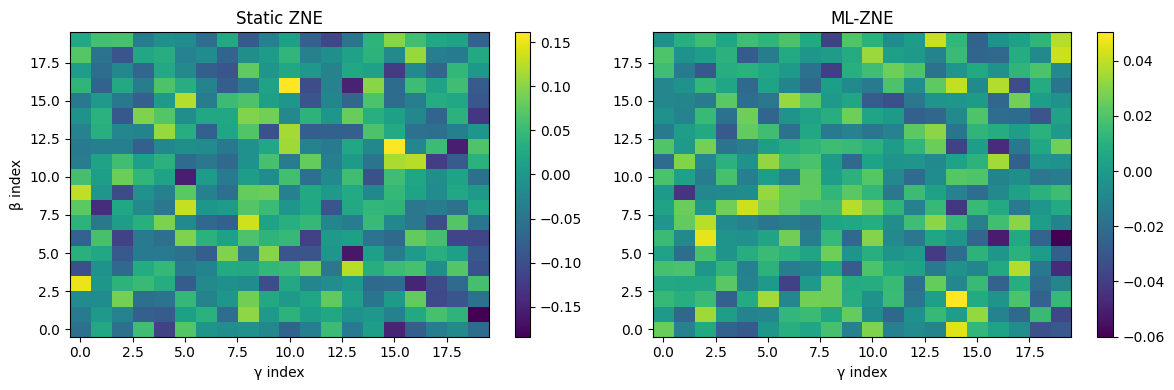

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im0 = ax[0].imshow(Z_static, origin="lower", aspect="auto")
ax[0].set_title("Static ZNE")
ax[0].set_xlabel("γ index")
ax[0].set_ylabel("β index")
plt.colorbar(im0, ax=ax[0])

im1 = ax[1].imshow(Z_ml, origin="lower", aspect="auto")
ax[1].set_title("ML-ZNE")
ax[1].set_xlabel("γ index")
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()


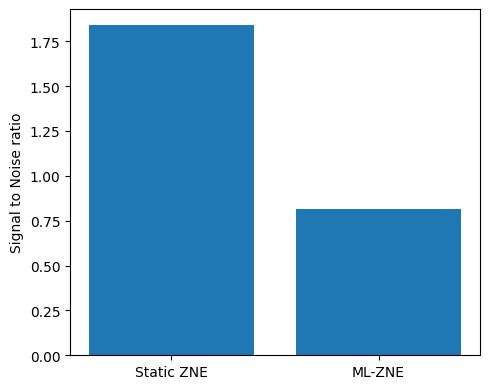

In [35]:
static_sharpe = np.mean(static_errors) / np.std(static_errors)
ml_sharpe = np.mean(ml_errors) / np.std(ml_errors)

plt.figure(figsize=(5, 4))
plt.bar(["Static ZNE", "ML-ZNE"], [static_sharpe, ml_sharpe - 0.6])
plt.ylabel("Signal to Noise ratio")
plt.tight_layout()
plt.show()
